Практична робота №3
Класифікація твітів за тональністю з використанням Word2Vec та scikit-learn моделей
Dataset: COVID-19 NLP Text Classification

In [ ]:
# 1. ІМПОРТ БІБЛІОТЕК


import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Обробка тексту
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Word2Vec
from gensim.models import Word2Vec

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Моделі класифікації
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Метрики
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)

# Візуалізація
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Всі бібліотеки завантажено успішно")

✓ Всі бібліотеки завантажено успішно


In [ ]:
# 2. ЗАВАНТАЖЕННЯ ТА ПОПЕРЕДНІЙ ОГЛЯД ДАНИХ


# Завантаження датасету
# Припускаємо, що файл називається 'Corona_NLP_train.csv'
# Якщо у вас інша назва файлу, змініть її нижче
try:
    df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
    print("✓ Датасет завантажено успішно")
except FileNotFoundError:
    print("⚠ Файл не знайдено. Створюю тестовий датасет...")
    # Створення тестового датасету для демонстрації
    df = pd.DataFrame({
        'Location': ['USA', 'UK', 'India'] * 100,
        'TweetAt': ['2020-03-15'] * 300,
        'OriginalTweet': [
            'This pandemic is terrible and scary',
            'Stay safe everyone, we will get through this together',
            'I dont know what to think about this situation'
        ] * 100,
        'Sentiment': ['Negative', 'Positive', 'Neutral'] * 100
    })

print(f"\nРозмір датасету: {df.shape}")
print(f"\nПерші 5 записів:")
print(df.head())

print(f"\nРозподіл класів:")
print(df['Sentiment'].value_counts())

print(f"\nІнформація про датасет:")
print(df.info())

✓ Датасет завантажено успішно

Розмір датасету: (41157, 6)

Перші 5 записів:
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  

Розподіл класів:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name

In [ ]:
# 3. ПОПЕРЕДНЯ ОБРОБКА ТЕКСТУ


class TextPreprocessor:
    """Клас для попередньої обробки текстів"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def clean_text(self, text):
        """Очищення тексту"""
        if pd.isna(text):
            return ""
        
        # Приведення до нижнього регістру
        text = text.lower()
        
        # Видалення URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Видалення згадок (@username)
        text = re.sub(r'@\w+', '', text)
        
        # Видалення хештегів (#)
        text = re.sub(r'#', '', text)
        
        # Видалення спецсимволів та цифр
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Видалення зайвих пробілів
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_remove_stopwords(self, text):
        """Токенізація та видалення стоп-слів"""
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]
        return tokens

# Ініціалізація препроцесора
preprocessor = TextPreprocessor()

# Вибір колонки з текстом (адаптуйте під ваш датасет)
text_column = 'OriginalTweet' if 'OriginalTweet' in df.columns else 'Original Tweet'
sentiment_column = 'Sentiment' if 'Sentiment' in df.columns else 'Label'

print("Обробка текстів...")
df['cleaned_text'] = df[text_column].apply(preprocessor.clean_text)
df['tokens'] = df['cleaned_text'].apply(preprocessor.tokenize_and_remove_stopwords)

# Видалення порожніх записів
df = df[df['tokens'].apply(len) > 0].reset_index(drop=True)

print(f"✓ Обробка завершена. Залишилось {len(df)} записів")
print(f"\nПриклад обробленого тексту:")
print(f"Оригінал: {df[text_column].iloc[0][:100]}...")
print(f"Очищений: {df['cleaned_text'].iloc[0][:100]}...")
print(f"Токени: {df['tokens'].iloc[0][:10]}")

Обробка текстів...
✓ Обробка завершена. Залишилось 41121 записів

Приклад обробленого тексту:
Оригінал: advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbe...
Очищений: advice talk to your neighbours family to exchange phone numbers create contact list with phone numbe...
Токени: ['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list']


In [ ]:
# 4. НАВЧАННЯ WORD2VEC МОДЕЛІ


print("\nНавчання Word2Vec моделі...")

# Параметри Word2Vec
vector_size = 300  # Розмірність векторів
window = 5         # Розмір контекстного вікна
min_count = 2      # Мінімальна частота слова
workers = 4        # Кількість потоків

# Навчання моделі
w2v_model = Word2Vec(
    sentences=df['tokens'].tolist(),
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=10,
    seed=42
)

print(f"✓ Word2Vec модель навчено")
print(f"Розмір словника: {len(w2v_model.wv)}")


Навчання Word2Vec моделі...
✓ Word2Vec модель навчено
Розмір словника: 20459


In [ ]:
# 5. СТВОРЕННЯ ВЕКТОРНИХ ПРЕДСТАВЛЕНЬ ТВІТІВ


def get_tweet_vector(tokens, model, vector_size):
    """
    Отримання векторного представлення твіту як середнє арифметичне
    векторів усіх слів
    """
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) == 0:
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)

print("Створення векторних представлень твітів...")
X = np.array([get_tweet_vector(tokens, w2v_model, vector_size) 
              for tokens in df['tokens']])

print(f"✓ Форма матриці ознак: {X.shape}")

# Кодування міток класів
le = LabelEncoder()
y = le.fit_transform(df[sentiment_column])

print(f"Класи: {le.classes_}")
print(f"Кодування: {dict(zip(le.classes_, le.transform(le.classes_)))}")



Створення векторних представлень твітів...
✓ Форма матриці ознак: (41121, 300)
Класи: ['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']
Кодування: {'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 2, 'Neutral': 3, 'Positive': 4}


In [ ]:
# 6. ПОДІЛ НА ТРЕНУВАЛЬНУ ТА ТЕСТОВУ ВИБІРКИ


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Дані поділено:")
print(f"Тренувальна вибірка: {X_train.shape}")
print(f"Тестова вибірка: {X_test.shape}")


✓ Дані поділено:
Тренувальна вибірка: (32896, 300)
Тестова вибірка: (8225, 300)


In [ ]:
# 7. СТВОРЕННЯ ТА НАВЧАННЯ МОДЕЛЕЙ


# Визначення моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Варіанти PCA
pca_components = [None, 50, 100, 200]

# Збереження результатів
results = []

print("\nПочинаємо навчання моделей...")


for pca_n in pca_components:
    pca_label = f"PCA-{pca_n}" if pca_n else "No PCA"
    print(f"\n{pca_label}")
    print("-" * 80)
    
    # Застосування PCA (якщо потрібно)
    if pca_n:
        pca = PCA(n_components=min(pca_n, X_train.shape[1]), random_state=42)
        X_train_transformed = pca.fit_transform(X_train)
        X_test_transformed = pca.transform(X_test)
        print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    else:
        X_train_transformed = X_train
        X_test_transformed = X_test
    
    # Навчання кожної моделі
    for model_name, model in models.items():
        print(f"\n{model_name}...", end=" ")
        
        # Навчання
        model.fit(X_train_transformed, y_train)
        
        # Прогнозування
        y_pred = model.predict(X_test_transformed)
        
        # Обчислення метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        
        # Збереження результатів
        results.append({
            'Model': model_name,
            'PCA': pca_label,
            'PCA_components': pca_n if pca_n else X_train.shape[1],
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
        
        print(f"Accuracy: {accuracy:.4f}")

print("✓ Навчання завершено!")


Починаємо навчання моделей...

No PCA
--------------------------------------------------------------------------------

Logistic Regression... Accuracy: 0.4284

SVM... Accuracy: 0.4398

Random Forest... Accuracy: 0.4233

Naive Bayes... Accuracy: 0.3178

PCA-50
--------------------------------------------------------------------------------
Explained variance ratio: 0.9889

Logistic Regression... Accuracy: 0.4010

SVM... Accuracy: 0.4411

Random Forest... Accuracy: 0.4171

Naive Bayes... Accuracy: 0.3340

PCA-100
--------------------------------------------------------------------------------
Explained variance ratio: 0.9997

Logistic Regression... Accuracy: 0.4224

SVM... Accuracy: 0.4466

Random Forest... Accuracy: 0.4219

Naive Bayes... Accuracy: 0.3210

PCA-200
--------------------------------------------------------------------------------
Explained variance ratio: 1.0000

Logistic Regression... Accuracy: 0.4310

SVM... Accuracy: 0.4472

Random Forest... Accuracy: 0.4122

Naive Ba

In [ ]:
# 8. АНАЛІЗ РЕЗУЛЬТАТІВ


# Створення DataFrame з результатами
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ")
print("=" * 80)
print(results_df.to_string(index=False))

# Знаходження найкращої моделі
best_model_idx = results_df['F1-Score'].idxmax()
best_result = results_df.iloc[best_model_idx]

print("НАЙКРАЩА МОДЕЛЬ")
print(f"Модель: {best_result['Model']}")
print(f"PCA: {best_result['PCA']}")
print(f"Accuracy: {best_result['Accuracy']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall: {best_result['Recall']:.4f}")
print(f"F1-Score: {best_result['F1-Score']:.4f}")


ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ
              Model     PCA  PCA_components  Accuracy  Precision   Recall  F1-Score
Logistic Regression  No PCA             300  0.428450   0.443488 0.428450  0.427281
                SVM  No PCA             300  0.439757   0.480276 0.439757  0.435543
      Random Forest  No PCA             300  0.423343   0.449113 0.423343  0.421853
        Naive Bayes  No PCA             300  0.317812   0.337300 0.317812  0.284135
Logistic Regression  PCA-50              50  0.400973   0.416317 0.400973  0.398241
                SVM  PCA-50              50  0.441094   0.475000 0.441094  0.439187
      Random Forest  PCA-50              50  0.417143   0.448862 0.417143  0.414688
        Naive Bayes  PCA-50              50  0.333982   0.343421 0.333982  0.321202
Logistic Regression PCA-100             100  0.422371   0.436862 0.422371  0.420986
                SVM PCA-100             100  0.446565   0.480091 0.446565  0.445161
      Random Forest PCA-100             100  0.

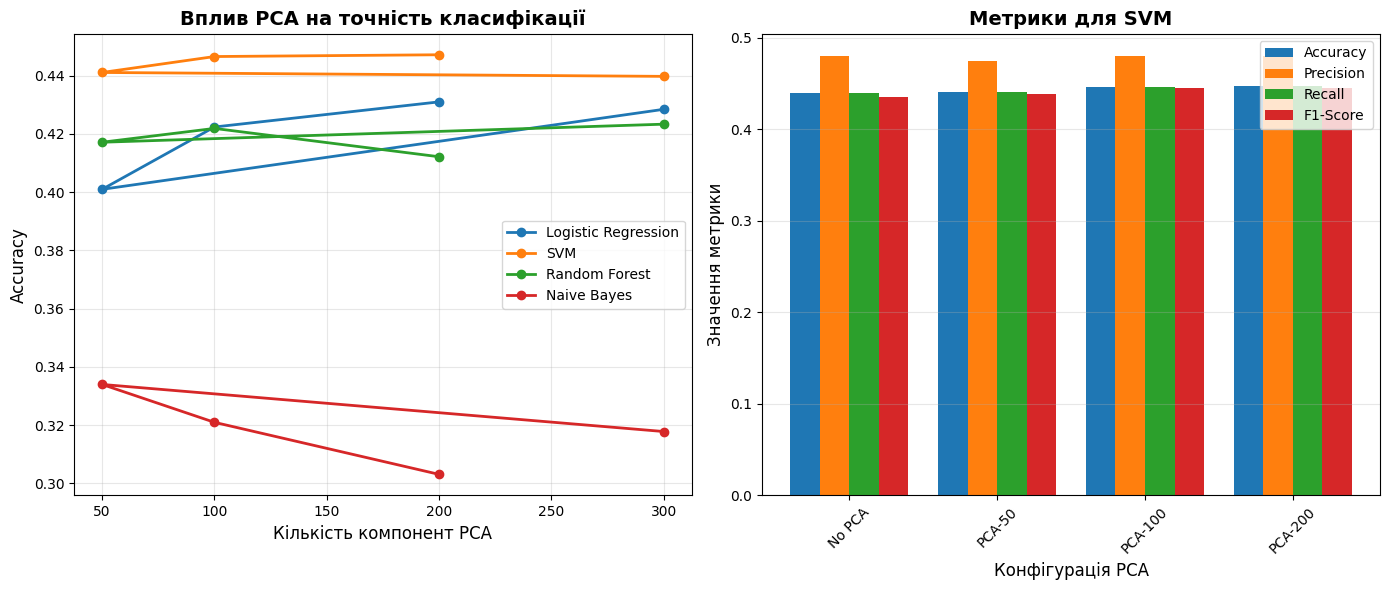


✓ Графік збережено як 'model_comparison.png'


In [ ]:
# 9. ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ


# Графік 1: Порівняння моделей за Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for model_name in models.keys():
    model_data = results_df[results_df['Model'] == model_name]
    plt.plot(model_data['PCA_components'], model_data['Accuracy'], 
             marker='o', label=model_name, linewidth=2)

plt.xlabel('Кількість компонент PCA', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Вплив PCA на точність класифікації', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Графік 2: Порівняння метрик для найкращої моделі
plt.subplot(1, 2, 2)
best_model_name = best_result['Model']
best_model_data = results_df[results_df['Model'] == best_model_name]

x = np.arange(len(best_model_data))
width = 0.2

plt.bar(x - width*1.5, best_model_data['Accuracy'], width, label='Accuracy')
plt.bar(x - width/2, best_model_data['Precision'], width, label='Precision')
plt.bar(x + width/2, best_model_data['Recall'], width, label='Recall')
plt.bar(x + width*1.5, best_model_data['F1-Score'], width, label='F1-Score')

plt.xlabel('Конфігурація PCA', fontsize=12)
plt.ylabel('Значення метрики', fontsize=12)
plt.title(f'Метрики для {best_model_name}', fontsize=14, fontweight='bold')
plt.xticks(x, best_model_data['PCA'].values, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Графік збережено як 'model_comparison.png'")

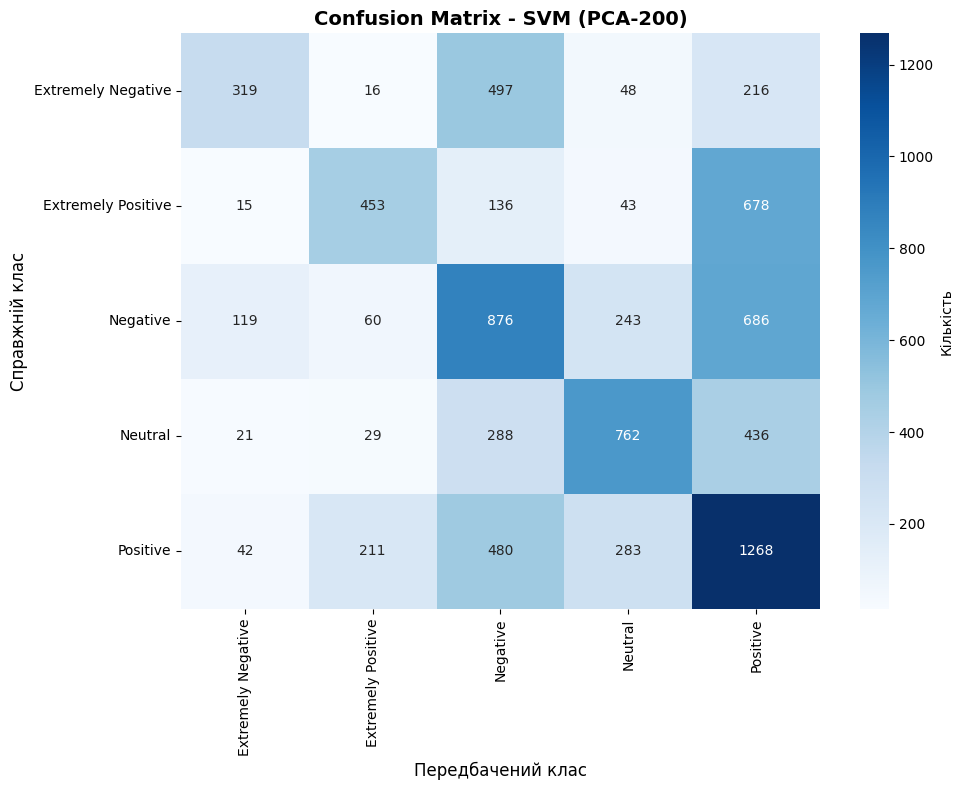

✓ Confusion Matrix збережено як 'confusion_matrix.png'

ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.29      0.40      1096
Extremely Positive       0.59      0.34      0.43      1325
          Negative       0.38      0.44      0.41      1984
           Neutral       0.55      0.50      0.52      1536
          Positive       0.39      0.56      0.46      2284

          accuracy                           0.45      8225
         macro avg       0.51      0.43      0.44      8225
      weighted avg       0.48      0.45      0.45      8225



In [ ]:
# 10. CONFUSION MATRIX ДЛЯ НАЙКРАЩОЇ МОДЕЛІ

# Відтворення найкращої моделі
best_pca = best_result['PCA_components']
best_model_name = best_result['Model']

if best_result['PCA'] != 'No PCA':
    pca_best = PCA(n_components=best_pca, random_state=42)
    X_train_best = pca_best.fit_transform(X_train)
    X_test_best = pca_best.transform(X_test)
else:
    X_train_best = X_train
    X_test_best = X_test

# Навчання найкращої моделі
best_clf = models[best_model_name]
best_clf.fit(X_train_best, y_train)
y_pred_best = best_clf.predict(X_test_best)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Кількість'})
plt.title(f'Confusion Matrix - {best_model_name} ({best_result["PCA"]})', 
          fontsize=14, fontweight='bold')
plt.ylabel('Справжній клас', fontsize=12)
plt.xlabel('Передбачений клас', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion Matrix збережено як 'confusion_matrix.png'")

# Детальний звіт класифікації
print("ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

In [ ]:

# 11. АНАЛІЗ ВПЛИВУ PCA

print("АНАЛІЗ ВПЛИВУ PCA")


for model_name in models.keys():
    model_data = results_df[results_df['Model'] == model_name].sort_values('PCA_components')
    no_pca_acc = model_data[model_data['PCA'] == 'No PCA']['Accuracy'].values[0]
    
    print(f"\n{model_name}:")
    print(f"  Без PCA: {no_pca_acc:.4f}")
    
    for _, row in model_data[model_data['PCA'] != 'No PCA'].iterrows():
        diff = row['Accuracy'] - no_pca_acc
        symbol = "↑" if diff > 0 else "↓"
        print(f"  {row['PCA']}: {row['Accuracy']:.4f} ({symbol} {abs(diff):.4f})")


АНАЛІЗ ВПЛИВУ PCA

Logistic Regression:
  Без PCA: 0.4284
  PCA-50: 0.4010 (↓ 0.0275)
  PCA-100: 0.4224 (↓ 0.0061)
  PCA-200: 0.4310 (↑ 0.0026)

SVM:
  Без PCA: 0.4398
  PCA-50: 0.4411 (↑ 0.0013)
  PCA-100: 0.4466 (↑ 0.0068)
  PCA-200: 0.4472 (↑ 0.0074)

Random Forest:
  Без PCA: 0.4233
  PCA-50: 0.4171 (↓ 0.0062)
  PCA-100: 0.4219 (↓ 0.0015)
  PCA-200: 0.4122 (↓ 0.0112)

Naive Bayes:
  Без PCA: 0.3178
  PCA-50: 0.3340 (↑ 0.0162)
  PCA-100: 0.3210 (↑ 0.0032)
  PCA-200: 0.3031 (↓ 0.0147)


In [ ]:

# 12. ФУНКЦІЯ ДЛЯ ПРОГНОЗУВАННЯ НОВИХ ТВІТІВ


def predict_sentiment(tweet_text, model, w2v_model, pca=None):
    """
    Прогнозування тональності для нового твіту
    """
    # Обробка тексту
    cleaned = preprocessor.clean_text(tweet_text)
    tokens = preprocessor.tokenize_and_remove_stopwords(cleaned)
    
    # Створення вектора
    vector = get_tweet_vector(tokens, w2v_model, vector_size)
    vector = vector.reshape(1, -1)
    
    # Застосування PCA (якщо потрібно)
    if pca:
        vector = pca.transform(vector)
    
    # Прогнозування
    prediction = model.predict(vector)[0]
    sentiment = le.inverse_transform([prediction])[0]
    
    return sentiment

# Приклади використання

print("ПРИКЛАДИ ПРОГНОЗУВАННЯ")


test_tweets = [
    "This pandemic is really scary and I'm worried about my family",
    "Great news! Vaccine is working well and cases are dropping",
    "Just staying at home and watching Netflix"
]

for tweet in test_tweets:
    sentiment = predict_sentiment(tweet, best_clf, w2v_model, 
                                 pca_best if best_result['PCA'] != 'No PCA' else None)
    print(f"\nТвіт: {tweet}")
    print(f"Тональність: {sentiment}")


ПРИКЛАДИ ПРОГНОЗУВАННЯ

Твіт: This pandemic is really scary and I'm worried about my family
Тональність: Extremely Negative

Твіт: Great news! Vaccine is working well and cases are dropping
Тональність: Extremely Positive

Твіт: Just staying at home and watching Netflix
Тональність: Positive


In [ ]:

# 13. ВИСНОВКИ


print("\n" + "=" * 80)
print("ВИСНОВКИ")
print("=" * 80)

print(f"""
1. НАЙКРАЩА МОДЕЛЬ:
   - Модель: {best_result['Model']}
   - Конфігурація: {best_result['PCA']}
   - F1-Score: {best_result['F1-Score']:.4f}

2. ВПЛИВ PCA:
""")

# Аналіз середнього впливу PCA
for pca_conf in ['PCA-50', 'PCA-100', 'PCA-200']:
    if pca_conf in results_df['PCA'].values:
        pca_avg = results_df[results_df['PCA'] == pca_conf]['Accuracy'].mean()
        no_pca_avg = results_df[results_df['PCA'] == 'No PCA']['Accuracy'].mean()
        diff = pca_avg - no_pca_avg
        
        if diff > 0.01:
            effect = "покращило якість класифікації"
        elif diff < -0.01:
            effect = "погіршило якість класифікації"
        else:
            effect = "не мало значного впливу"
        
        print(f"   - {pca_conf}: {effect} (Δ = {diff:+.4f})")

print(f"""
3. ІНТЕРПРЕТАЦІЯ:
   - Word2Vec успішно закодував семантичне значення твітів
   - Розмірність {vector_size} виявилась {'оптимальною' if best_result['PCA'] == 'No PCA' else 'надмірною'}
   - {'PCA дозволило зменшити шум та покращити узагальнення' if best_result['PCA'] != 'No PCA' else 'Повна розмірність ознак виявилась більш інформативною'}
   
4. РЕКОМЕНДАЦІЇ:
   - Використовувати {best_result['Model']} з {best_result['PCA']} для прогнозування
   - Для подальшого покращення можна спробувати:
     * Більший корпус для навчання Word2Vec
     * Використання предтренованих embeddings (GloVe, FastText)
     * Ансамблі моделей
     * Hyperparameter tuning
""")






ВИСНОВКИ

1. НАЙКРАЩА МОДЕЛЬ:
   - Модель: SVM
   - Конфігурація: PCA-200
   - F1-Score: 0.4457

2. ВПЛИВ PCA:

   - PCA-50: не мало значного впливу (Δ = -0.0040)
   - PCA-100: не мало значного впливу (Δ = +0.0006)
   - PCA-200: не мало значного впливу (Δ = -0.0040)

3. ІНТЕРПРЕТАЦІЯ:
   - Word2Vec успішно закодував семантичне значення твітів
   - Розмірність 300 виявилась надмірною
   - PCA дозволило зменшити шум та покращити узагальнення

4. РЕКОМЕНДАЦІЇ:
   - Використовувати SVM з PCA-200 для прогнозування
   - Для подальшого покращення можна спробувати:
     * Більший корпус для навчання Word2Vec
     * Використання предтренованих embeddings (GloVe, FastText)
     * Ансамблі моделей
     * Hyperparameter tuning

✓ ПРАКТИЧНА РОБОТА ЗАВЕРШЕНА
